In [1]:
%reset -f

In [2]:
import torch
%matplotlib inline
from matplotlib import pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
def get_phi(x):
    out = torch.zeros_like(x)
    mask1 = (x >= 0) & (x < 1)
    out[mask1] = 1.0
    mask2 = (x < 0) | (x >= 1)
    out[mask2] = 0.0
    return out


In [4]:
def get_psi(x):
    out = torch.zeros_like(x)
    mask1 = (x >= 0) & (x < 0.5)
    out[mask1] = 1.0
    mask2 = (x >= 0.5 ) & (x < 1)
    out[mask2] = -1.0
    mask3 = (x < 0 ) | (x >= 1)
    out[mask3] = 0.0
    return out

In [5]:
x = torch.arange(0,1,1/10000)
phi_x = get_phi(x)
# plt.plot(x.numpy(), phi_x.numpy())
# plt.show()

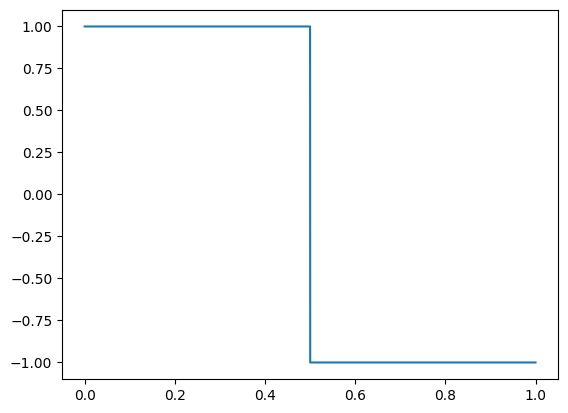

In [6]:
psi_x = get_psi(x)
plt.plot(x.numpy(), psi_x.numpy())
plt.show()

插值特性：$\phi(k)=\left\{\begin{array}{ll}
1, & k=0 \\
0, & k \neq 0
\end{array}\right.$

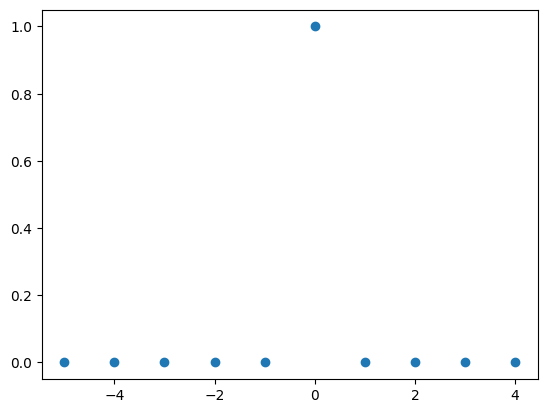

In [7]:
k = torch.arange(-5,5,1)
phi_k = get_phi(k)
plt.scatter(k.numpy(), phi_k.numpy())

双尺度关系：$\phi(x)=\sum\limits_{k \cup Z} \phi(k / 2) \phi(2 x-k)$

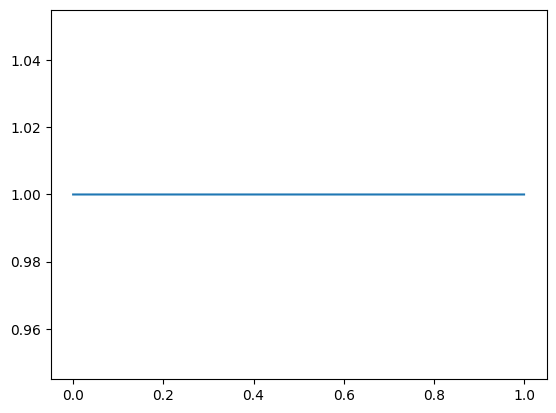

In [8]:
res = 0
for k in range(-5, 5):
    k = torch.tensor(k)
    res += get_phi(k/2)*get_phi(2*x-k)
plt.plot(x.numpy(), res.numpy())

多项式张成：对整数$D\ge0$，$\sum\limits_{k \in Z}C_k\phi(x-k)$能覆盖所有D阶多项式函数

对某一个正实数$R>0$，$\phi$是$R$阶Holder连续的，即
$$\big|\phi(y)-\phi(x)\big|\leq C\big|y-x\big|^R,\quad\forall x,y\in R$$

局部性：$\phi$及其$\lfloor m \rfloor$阶导数是紧支撑的，即：
$$\begin{aligned}\left|\phi^m(x)\right|\leq A_s\left(1+\left|x\right|\right)^{-s},\quad x\in R,\quad s>0,\quad0\leq m\leq\left\lfloor R\right\rfloor\end{aligned}$$

定义尺度函数序列为：$\phi_{j,k}(x)=\phi(2^j\:x-k)\quad k= \{0, 1, ..., 2^j\}$

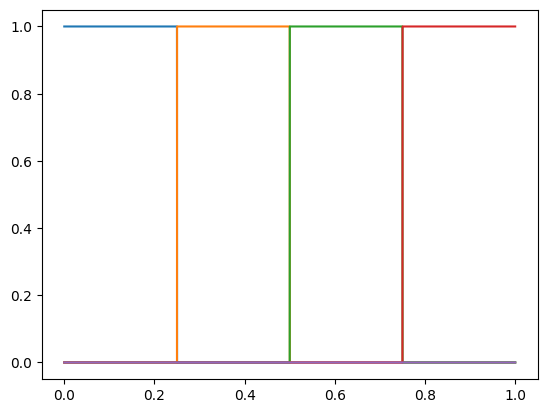

In [9]:
j = 2
for k in range(0, 2 ** j + 1):
    phi_jk = get_phi((2 ** j) * x - k)
    plt.plot(x.numpy(), phi_jk.numpy())

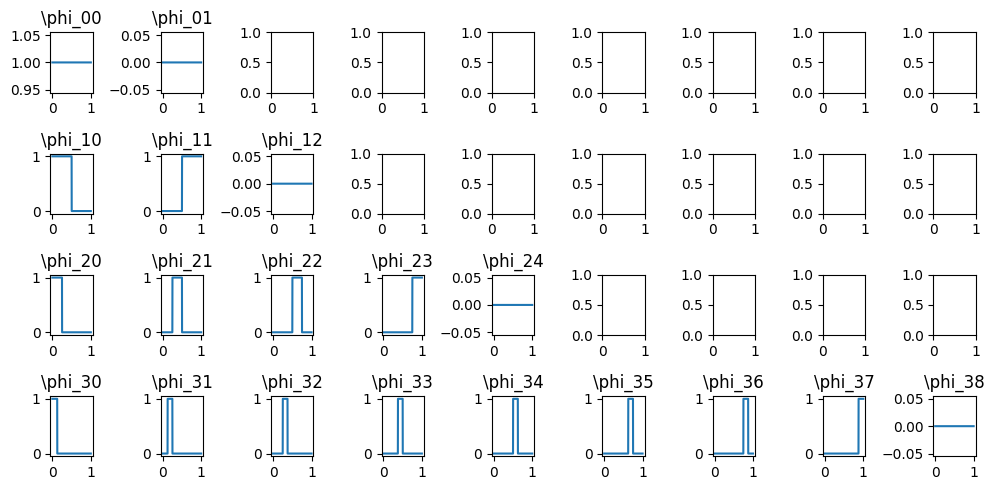

In [10]:
J = 3
fig, axs = plt.subplots(J+1, 2**J+1, figsize=(10, 5))
for j in range(J+1):
    k = torch.arange(0, 2 ** j + 1)
    for n, i in enumerate(k):
        phi_jk = get_phi((2 ** j) * x - i)
        ax = axs[j, n]
        ax.plot(x.numpy(), phi_jk.numpy())
        ax.set_title(f"\phi_{j}{n}")

plt.tight_layout()
plt.show()

In [11]:
n = 2
x_n = torch.tensor(n * 2 ** (-j))
for k in range(n-2,n+3):
    phi_jk_n2_j = get_phi((2 ** j) * x_n - k) ## n == k == 2
    phi_jk_n2_j = 0 if phi_jk_n2_j < 0.0001 else phi_jk_n2_j
    print("n={}, k={}, now phi_jk(n2^-j)={}".format(n, k, phi_jk_n2_j))

n=2, k=0, now phi_jk(n2^-j)=0
n=2, k=1, now phi_jk(n2^-j)=0
n=2, k=2, now phi_jk(n2^-j)=1.0
n=2, k=3, now phi_jk(n2^-j)=0
n=2, k=4, now phi_jk(n2^-j)=0


In [12]:
def get_Iwt_l(j, f):
    Ijf = 0
    for k in range(0, 2 ** j + 1):
        x_jk = torch.tensor(k * (2 ** (-j)))
        f_xjk = f(x_jk)
        phi_jk = get_phi((2 ** j) * x - k)
        Ijf += f_xjk * phi_jk
    return Ijf

In [13]:
def get_Iwt_r(j, f):
    Iwt_r = 0
    for k in range(0, 2 ** j):
        y_jk = torch.tensor((2*k+1) * (2 ** (-j-1)))
        f_yjk = f(y_jk)
        # mask = torch.eq(x, y_jk).type(torch.int)
        diff = torch.abs(x - y_jk)
        idx = torch.argmin(diff)
        mask = torch.zeros_like(x)
        mask[idx] = 1
        mask = mask.type(torch.int)
        indices = torch.nonzero(mask).reshape(-1)
        Ijf = get_Iwt_l(j, f)
        alpha = f_yjk - Ijf[indices] # 一个alpha
        psi_jk = get_phi((2 ** (j+1)) * x - (2*k+1))
        Iwt_r += alpha * psi_jk
    return Iwt_r

 $$u_J(x)=\sum\limits^{2^{j_0}}_{k_0=0}u(x_{j_0k_0})\phi_{j_0k_0}(x)+\sum\limits^{J-1}_{j=j_0}\sum\limits_{k \in Z^j}\alpha_{jk}\psi_{jk}(x)$$

In [14]:
def func(x):
    y = (x ** 3) - 1.5 * (x ** 2) + 0.5 * x
    return y*30

In [15]:
Iwt_l = 0
Iwt_r = 0
j0 = 0
J = 5
f = func
Iwt_l = get_Iwt_l(j0, f)
for j in range(j0, J):
    Iwt_r += get_Iwt_r(j, f)

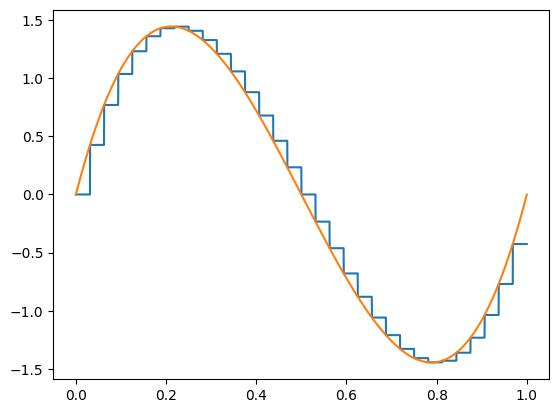

In [16]:
Uj = Iwt_l + Iwt_r
plt.plot(x.numpy(), Uj.numpy())
plt.plot(x.numpy(), f(x).numpy())
plt.show()


In [17]:
def func(x):
    y = (x ** 3) - 1.5 * (x ** 2) + 0.5 * x
    return y*30

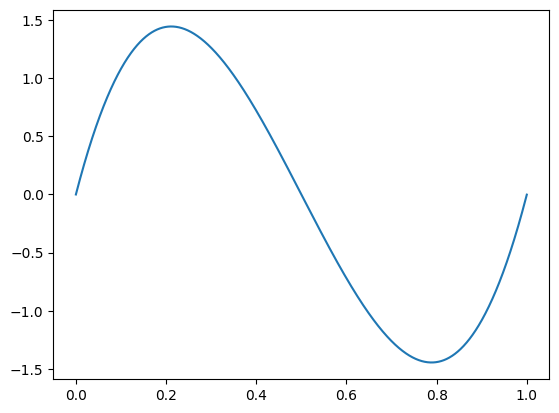

In [18]:
plt.plot(x.numpy(), func(x).numpy())